# Прогнозирование стоимости жилья: Шаг за шагом
![House](data/img.jpg "My dream house")

# Введение
### Цель:
В этом ноутбуке мы прогнозируем стоимость жилья с использованием моделей машинного обучения. Мы проведем исследование данных, их анализ, построим модели и оценим их качество.
### Данные: 
В анализе используется датасет "Housing.csv" с Kaggle, который содержит информацию о домах включая количество спален, ванных комнат, площадь и другие характеристики.
### Мотивация:
 Прогнозирование цен на жилье — это максимально актуальная задача в сфере недвижимости и финансов, позволяющая принимать обоснованные решения для покупателей, продавцов и инвесторов.

### Набор данных состоит из нескольких характеристик (колонок), которые описывают различные аспекты домов. Вот обзор основных столбцов:

Цена: Цена дома.
Площадь: Общая площадь дома в квадратных футах.
Спальни: Количество спален в доме.
Ванные комнаты: Количество ванных комнат в доме.
Этажи: Количество этажей в доме.
Главная дорога: Примыкает ли дом к главной дороге (да/нет).
Гостевая комната: Есть ли в доме комната для гостей (Да/Нет).
Подвал: Имеется ли в доме подвал (Да/Нет).
Отопление горячей водой: Есть ли в доме система отопления горячей водой (Да/Нет).
Кондиционирование воздуха: Есть ли в доме система кондиционирования (Да/Нет).
Парковка: Количество парковочных мест, имеющихся в доме.
Префария: Расположен ли дом в предпочтительном районе (Да/Нет).
Состояние меблировки: Статус меблировки дома (полностью меблирован, полумеблирован, немеблирован).

In [291]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## Предварительная обработка данных и их визуализация

In [292]:
df = pd.read_csv('data/Housing.csv')

In [293]:
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


### Проверяем датасет на пропущенные значения 
P.S. их по нулям, так что все круто

In [294]:
print(df.isna().sum())

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


### Смотрим на количество на уникальных значений, и исходя из этого затем проведем энкодинг

In [295]:
print(df.nunique())

price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64


In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [297]:
numeric_columns = df.select_dtypes(exclude=['object']).columns
numeric_columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object')

In [298]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')

### Посмотрим на матрицу корреляции
P.S. сильно коррелирующих нет - и это очень хорошо, но есть сильно слабая

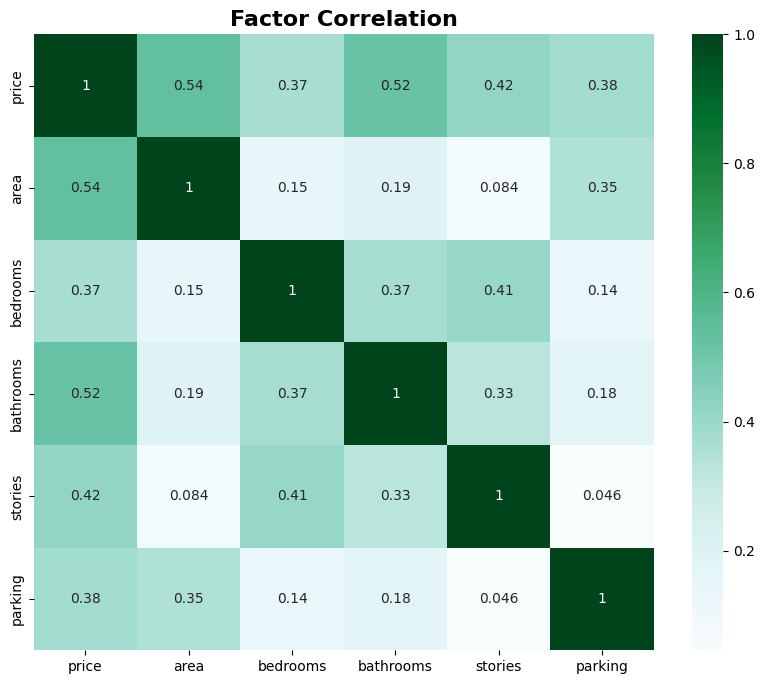

In [299]:
corr = df[numeric_columns].corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr, cmap = 'BuGn', annot = True)
plt.title("Factor Correlation", fontweight = "bold", fontsize=16)
plt.show()

### Посмотрим на квазиконстантые признаки


In [300]:
from sklearn.feature_selection import VarianceThreshold

cutter = VarianceThreshold(threshold=0.1)
cutter.fit(df[numeric_columns])
print(cutter.get_feature_names_out())
print(numeric_columns)

['price' 'area' 'bedrooms' 'bathrooms' 'stories' 'parking']
Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object')


Как оказалось, таких у нас тоже нет

 Большинство алгоритмов машинного обучения не могут работать напрямую с категориальными данными, такими как строки. Они требуют числовых входных данных для вычислений. Исправим это)

In [301]:
from sklearn.preprocessing import LabelEncoder

for col in categorical_columns:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])

### Попробуем проследить корреляцию между ценой и площадью наглядно через график

<Axes: xlabel='area', ylabel='price'>

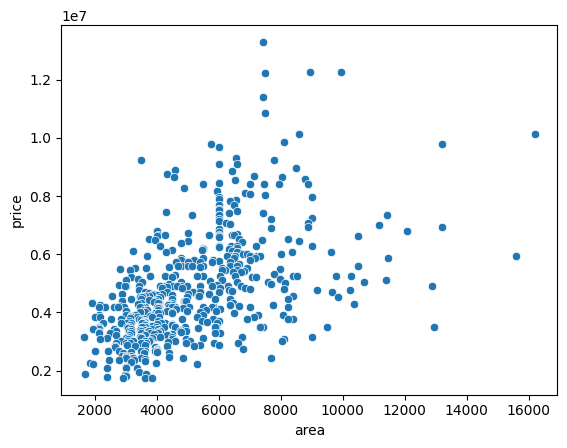

In [302]:
sns.scatterplot(df, x='area', y='price')

У нас есть выбросы и чтобы от них избавиться, нужно понять каким образом выглядит распределение нашего тагрета

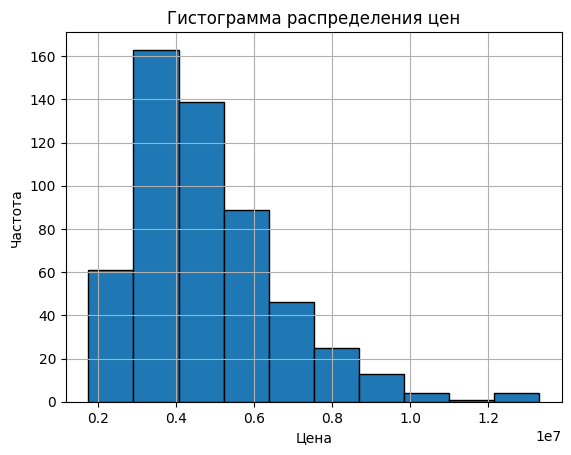

In [303]:
df['price'].hist(bins=10, edgecolor='black')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Гистограмма распределения цен')
plt.show()

Или так

In [304]:
from scipy.stats import shapiro
stat, p_value = shapiro(df['price'])
print(f'Стоимость имеет нормальное распределение.') if (p_value > 0.05) else print(f'Стоимость не имеет нормальное распределение.')

Стоимость не имеет нормальное распределение.


So... Распределение не является нормальным, поэтому воспользуемся Z-оценкой.
Уберем заоблачные цены и нестандартные по площади квартиры, так как в общем и целом они не в той мере отражают суть

In [305]:
# вычисление Z-оценки для колонки 'price'
df.loc[:, 'Z_score'] = (df['price'] - df['price'].mean()) / df['price'].std()
df = df[df['Z_score'].abs() <= 3]

# вычисление Z-оценки для колонки 'area'
df.loc[:, 'Z_score1'] = (df['area'] - df['area'].mean()) / df['area'].std()
df = df[df['Z_score1'].abs() <= 3]

# удаление колонок с Z-оценками
df = df.drop(columns=['Z_score', 'Z_score1'])

Посмотрим на взаимосвязь категориальных колонок с нашим таргетом

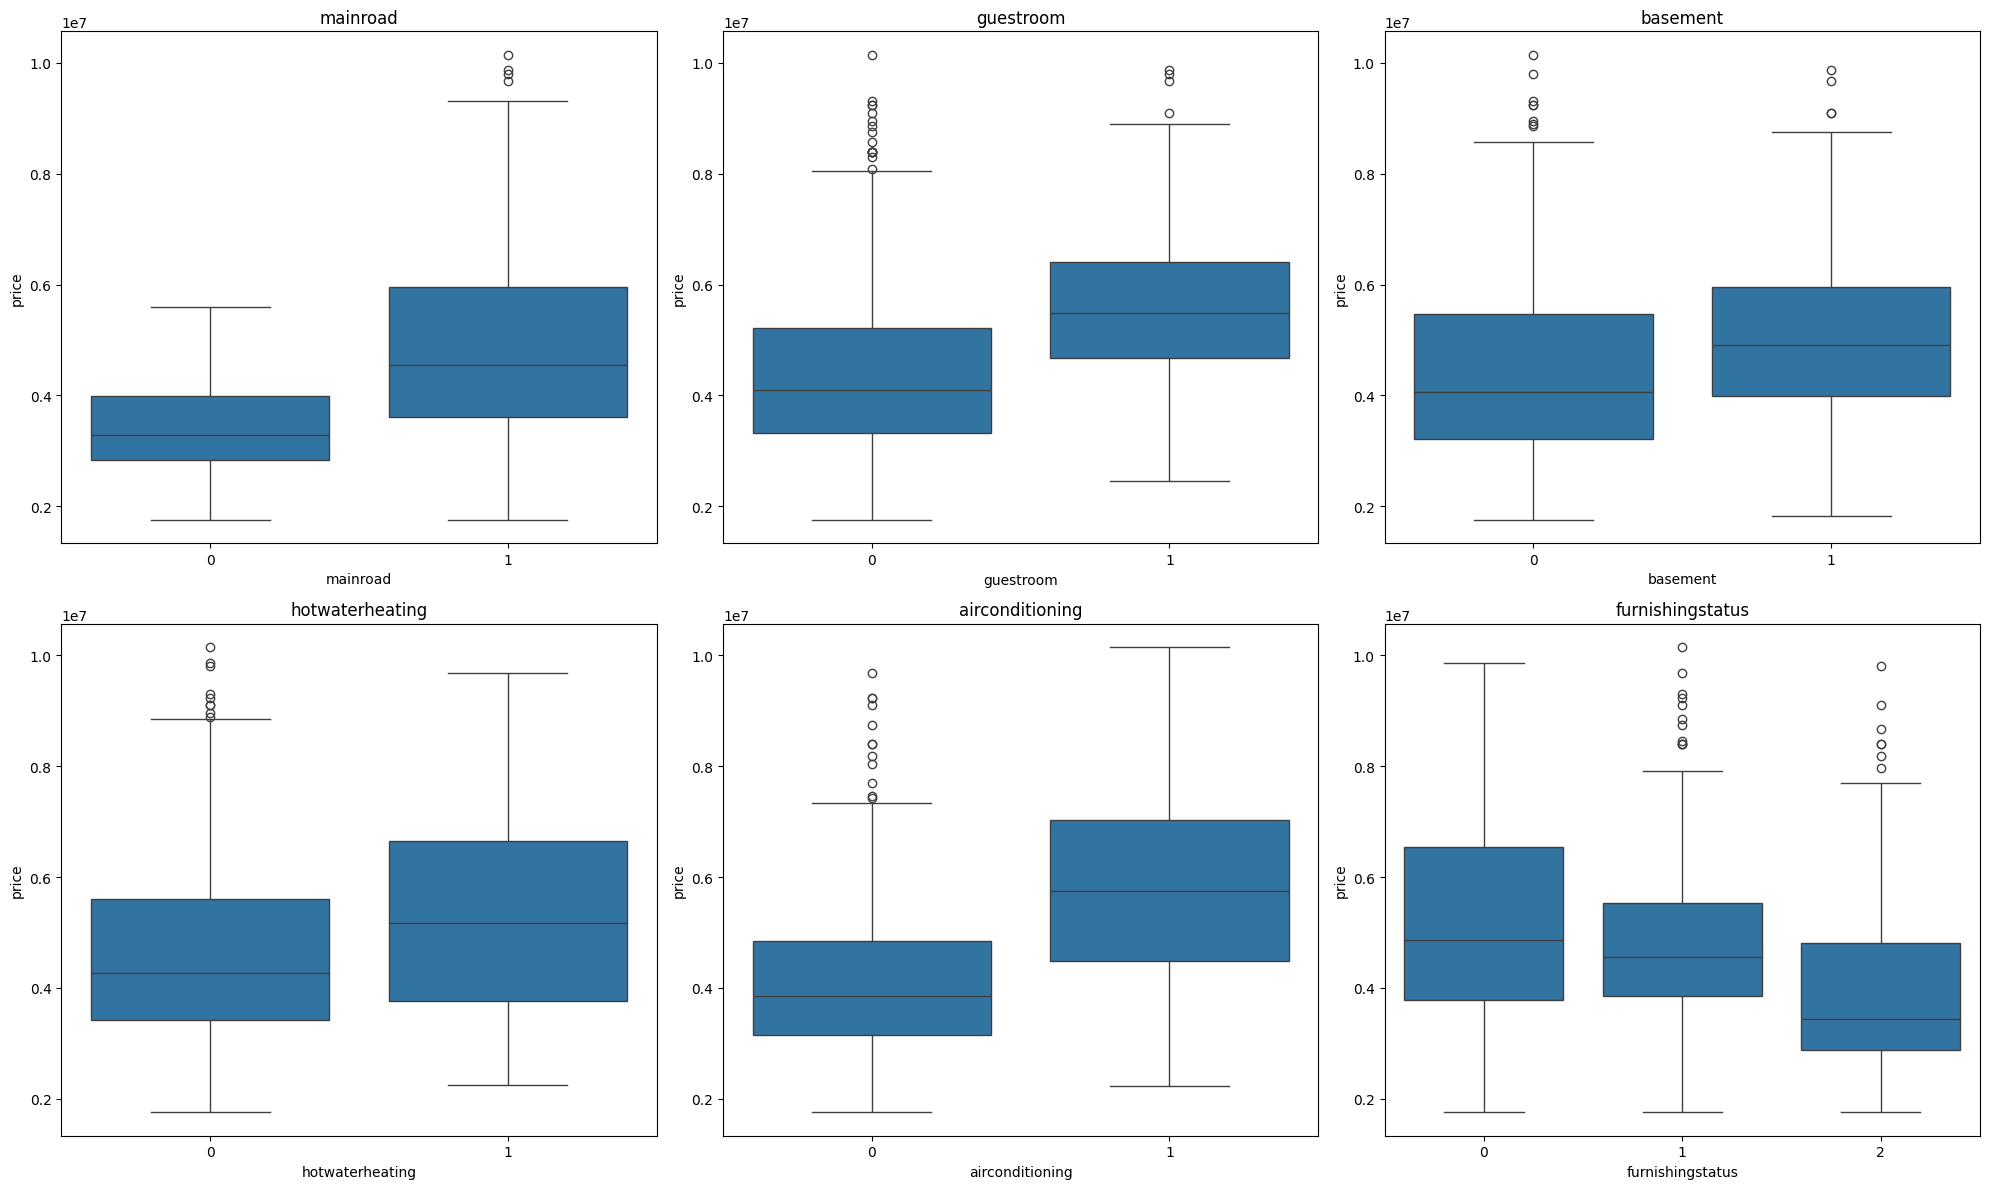

In [306]:
plt.figure(figsize=(20, 12))

columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'furnishingstatus']

for i, column in enumerate(columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=column, y='price', data=df)
    plt.title(column)

plt.tight_layout()  
plt.show()

### Часть из этих колонок мы отнесли к численным, но на самом деле они подразумевают собой категории
Применяем One-Hot Encoding
Спойлер: Ухудшает качество модели

In [307]:
# cat_columns = ['bedrooms', 'bathrooms', 'stories', 'furnishingstatus']
# for col in cat_columns:
# 
#     one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True, dtype=int)
#     df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

## Обучаем модель

In [308]:
X = df.drop('price', axis=1)
Y = df['price']

In [309]:
# делим датасет на тренировочный и тестовый
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    random_state=0, 
                                                    test_size=0.2)

In [310]:
X_train.shape[0], X_test.shape[0]

(425, 107)

### Создаем универсальную функцию для обучения моделей

In [311]:
def evaluate_models(model, x_train, y_train, x_test, y_test):
    results = []

    for name, model in model.items():
        # создание пайплайна с моделью
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # обучение модели
        pipe.fit(x_train, y_train)
        
        # предсказание модели
        pred = pipe.predict(x_test)
        
        # оценка модели
        mse = mean_squared_error(y_test, pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, pred)
        
        # Сохранение результатов
        results.append({
            'Model': name,
            'RMSE': round(rmse, 2),
            'R2 Score': round(r2, 2)
        })
        plt.figure(figsize=(10, 6))
        plt.scatter(Y_test, pred, color='darkgreen', alpha=0.3)
        plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], '--r', color='blue')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.title(f'Actual vs. Predicted House Prices using {name}')

        plt.legend(['Data Points', 'Best Fit Line'], loc='upper left')
        plt.show()
    
    # возвращаем датасет с результатами
    return pd.DataFrame(results)



C:\Temp\ipykernel_34460\3206444675.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], '--r', color='blue')


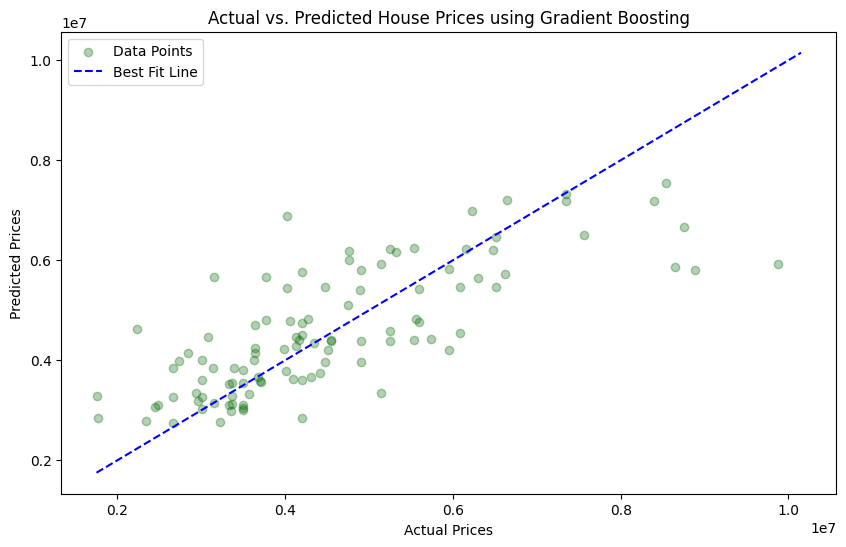

C:\Temp\ipykernel_34460\3206444675.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], '--r', color='blue')


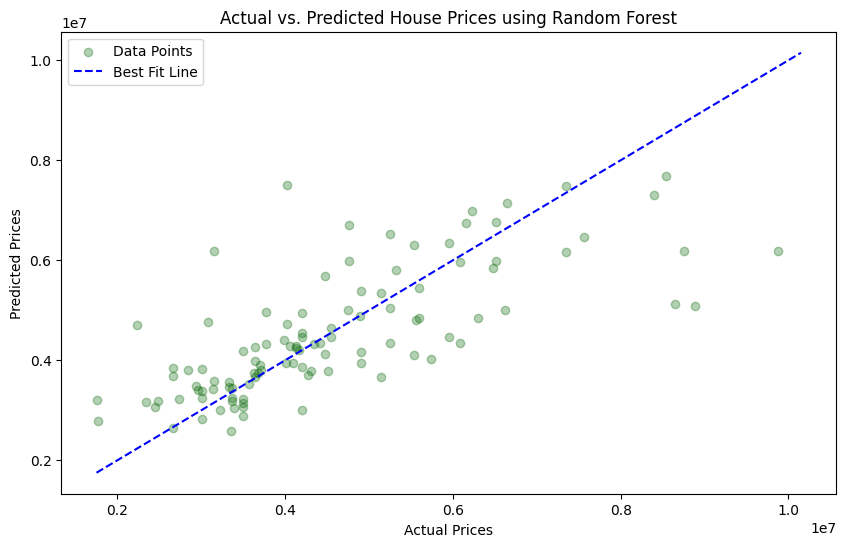

C:\Temp\ipykernel_34460\3206444675.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], '--r', color='blue')


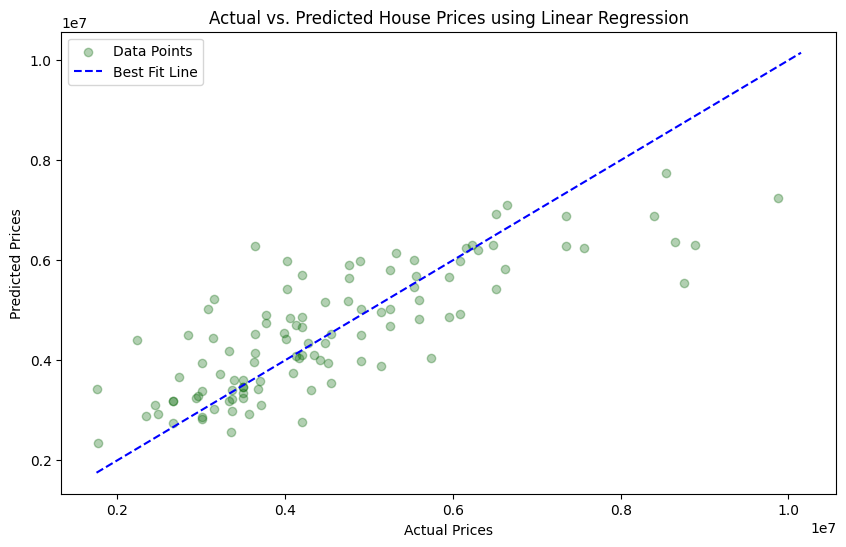

C:\Temp\ipykernel_34460\3206444675.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], '--r', color='blue')


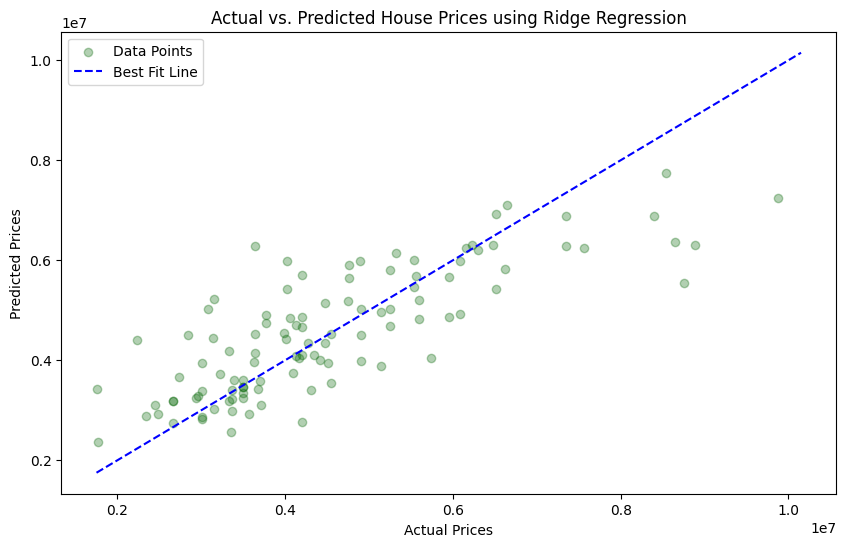

C:\Temp\ipykernel_34460\3206444675.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], '--r', color='blue')


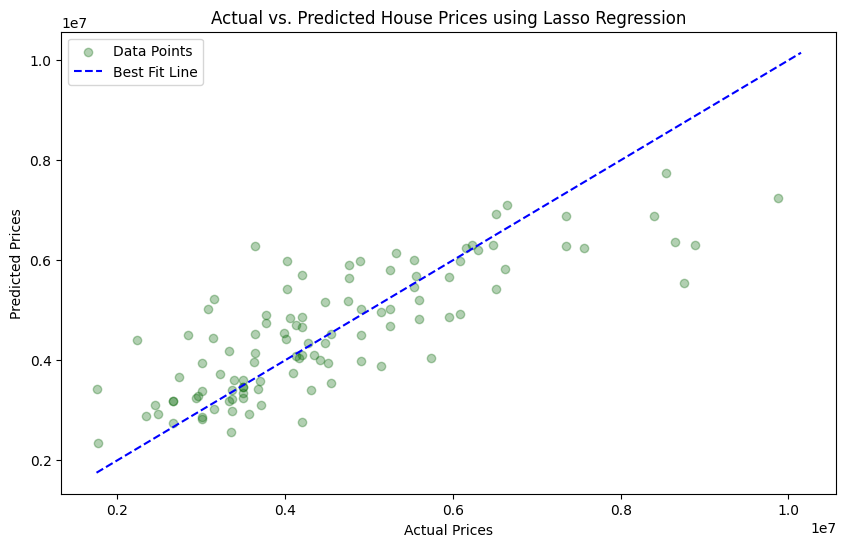

               Model        RMSE  R2 Score
0  Gradient Boosting  1057460.61      0.58
1      Random Forest  1114097.76      0.54
2  Linear Regression   984349.74      0.64
3   Ridge Regression   984142.44      0.64
4   Lasso Regression   984349.76      0.64


In [312]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# словарь моделей
models = {
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1)
}

# вывод оценки всех моделей
results_df = evaluate_models(models, X_train, Y_train, X_test, Y_test)
print(results_df)

# Благодарю за просмотр!
Буду рада любым новым идеям =)